In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

date_column_label = "Date"
y_label = "Good Surfing"

train_df = pd.read_csv('../data/processed/final_train.csv')
val_df = pd.read_csv('../data/processed/final_val.csv')
test_df = pd.read_csv('../data/processed/final_test.csv')

train_df[date_column_label] = pd.to_datetime(train_df[date_column_label])

val_df[date_column_label] = pd.to_datetime(val_df[date_column_label])
test_df[date_column_label] = pd.to_datetime(test_df[date_column_label])



In [70]:
# Data Split Step
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
import numpy as np
import time
import graphviz
import pydotplus
from IPython.display import Image

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# FP < 0.1 && FN < 0.2 
# 
X_train = train_df.drop(columns=[y_label, date_column_label])
Y_train = train_df[y_label]

X_val = val_df.drop(columns=[y_label, date_column_label])
Y_val = val_df[y_label]

X_test = test_df.drop(columns=[y_label, date_column_label])
Y_test = test_df[y_label]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

test_fold = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold=test_fold)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Combine the training and validation sets
X_train_val = pd.concat([pd.DataFrame(X_train, columns=X_train.columns), pd.DataFrame(X_val, columns=X_val.columns)])
X_train_val_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.DataFrame(X_val_scaled, columns=X_val.columns)])
Y_train_val = pd.concat([Y_train, Y_val])

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [8000, 9000, 10000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4], # add more value
        'max_features': [None, 'sqrt', 'log2']
    },
    'Gradient Boosting': {
        # 'n_estimators': [100, 200, 300],
        # 'learning_rate': [0.01, 0.1, 0.2],
        # 'max_depth': [3, 4, 5],
        # 'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4]
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'Neural Network': {
        # 'hidden_layer_sizes': [(50,), (100,), (150,)],
        # 'activation': ['tanh', 'relu'], # more values
        # 'solver': ['sgd', 'adam'],
        # 'alpha': [0.0001, 0.001, 0.01],
        # 'learning_rate': ['constant', 'adaptive'],
        # 'max_iter': [8000, 9000, 10000]
        'hidden_layer_sizes': [(50,), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [1000],
        'early_stopping': [True]  # Early stopping to prevent overfitting
    },
    'XGBoost': {
        # 'n_estimators': [100, 200], # less values
        # 'learning_rate': [0.01, 0.1],
        # 'max_depth': [3, 4],
        # 'subsample': [0.8, 1.0],
        # 'colsample_bytree': [0.8, 1.0]
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2],
        'min_child_weight': [1, 3, 5],
    },
    'CatBoost': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.1],
        'depth': [3, 4],
        'l2_leaf_reg': [1, 3, 5]
    }
}

# Dictionary to hold models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(silent=True)
}

scaled_models = ['Logistic Regression', 'Support Vector Machine', 'Neural Network']

scornig_label = 'scoring'
recall_label = 'recall'
f1_label = 'f1'
accuracy_label = 'accuracy'
precision_label = 'precision'


In [71]:
def plot_random_forest(forest, columns):
    estimator = forest.estimators_[0]
    dot_data = export_graphviz(estimator, out_file=None, feature_names=columns, filled=True, rounded=True, special_characters=True, max_depth=2)
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png()))

def plot_cm(Y, Y_pred, labels, title):
    cm = confusion_matrix(Y, Y_pred)
    cm = cm / np.sum(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format=".2%")
    disp.ax_.set_title(title)

def build_model(scoring, scoring_func):
    print(f'Setting {scoring} as scoring')
    best_models = {}
    for model_name, model in models.items():
        start_time = time.time()

        if model_name in scaled_models:
            search = GridSearchCV(model, param_grids[model_name], cv=ps, scoring=scoring, n_jobs=-1)
            search.fit(X_train_val_scaled, Y_train_val)
        else:
            search = RandomizedSearchCV(model, param_grids[model_name], cv=ps, scoring=scoring, n_jobs=-1, n_iter=20, random_state=42)
            search.fit(X_train_val, Y_train_val)
        
        best_models[model_name] = search.best_estimator_
        end_time = time.time()  # End time
        elapsed_time = end_time - start_time
        print(f"{model_name} - score: {search.best_score_:.4f}, Best HP: {search.best_params_}, took: {elapsed_time:.2f}s ")
    
    def get_scores(Y, Y_pred):
        accuracy = accuracy_score(Y, Y_pred)
        precision = precision_score(Y, Y_pred)
        recall = recall_score(Y, Y_pred)
        f1 = f1_score(Y, Y_pred)
        return f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}'
    
    model_scoring = {
        accuracy_label : {},
        precision_label : {},
        recall_label : {},
        f1_label: {},
        scornig_label: {}
    }

    for model_name, model in best_models.items():
        if model_name in scaled_models:
            Y_val_pred = model.predict(X_val_scaled)
        else:
            Y_val_pred = model.predict(X_val)
        
        model_scoring[accuracy_label][model_name] = accuracy_score(Y_val, Y_val_pred)
        model_scoring[precision_label][model_name] = precision_score(Y_val, Y_val_pred)
        model_scoring[recall_label][model_name] = recall_score(Y_val, Y_val_pred)
        model_scoring[f1_label][model_name] = f1_score(Y_val, Y_val_pred)
        model_scoring[scornig_label][model_name] = scoring_func(Y_val, Y_val_pred)

        print(f'{model_name} Validation: {get_scores(Y_val, Y_val_pred)}')
        plot_cm(Y_val, Y_val_pred, model.classes_, f'{model_name} Confusion Matrix - Validation Set')
        
        # if model_name == 'Random Forest':
        #     plot_random_forest(model, X_train.columns)
    
    best_model = max(model_scoring[scornig_label], key=model_scoring[scornig_label].get)
    print(f'Best Model: {best_model} for {scoring}: {model_scoring[scornig_label][best_model]}')

    # for model_name, model in best_models.items():
    #     if model_scoring[scornig_label][model_name] == 1 \
    #         and model_scoring[f1_label][model_name] == 1 \
    #         and model_scoring[accuracy_label][model_name] == 1 \
    #         and model_scoring[precision_label][model_name] == 1 \
    #         and model_scoring[recall_label][model_name] == 1: 
    #         del model_scoring[scornig_label][model_name]
    
    # sec_best_model = max(model_scoring[scornig_label], key=model_scoring[scornig_label].get)
    # print(f'Best Non-Overfitting Model: {sec_best_model} for {scoring}: {model_scoring[scornig_label][sec_best_model]}')

    best = {
        best_model : best_models[best_model],
        # sec_best_model: best_models[sec_best_model]
    }

    for m, m_inst in best.items():
        if m in scaled_models:
            m_inst.fit(X_train_scaled, Y_train)
            Y_test_pred = m_inst.predict(X_test_scaled)
        else:
            m_inst.fit(X_train, Y_train)
            Y_test_pred = m_inst.predict(X_test)
        
        print(f'{m} Test: {get_scores(Y_test, Y_test_pred)}')
        plot_cm(Y_test, Y_test_pred, m_inst.classes_, f'{m} Confusion Matrix - Test Set')

Setting precision as scoring
Logistic Regression - score: 0.7432, Best HP: {'C': 0.01, 'max_iter': 8000, 'solver': 'lbfgs'}, took: 21.73s 
Random Forest - score: 0.8235, Best HP: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}, took: 61.30s 
Gradient Boosting - score: 0.7945, Best HP: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}, took: 2.31s 
Support Vector Machine - score: 0.7714, Best HP: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, took: 15.60s 
Naive Bayes - score: 0.6593, Best HP: {'var_smoothing': 1e-09}, took: 0.15s 
Neural Network - score: 0.7826, Best HP: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}, took: 3.05s 
XGBoost - score: 0.7973, Best HP: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 

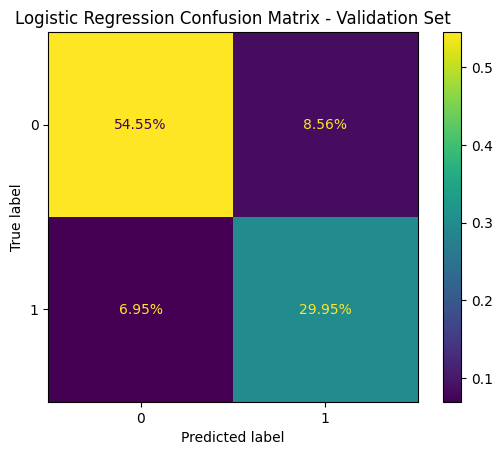

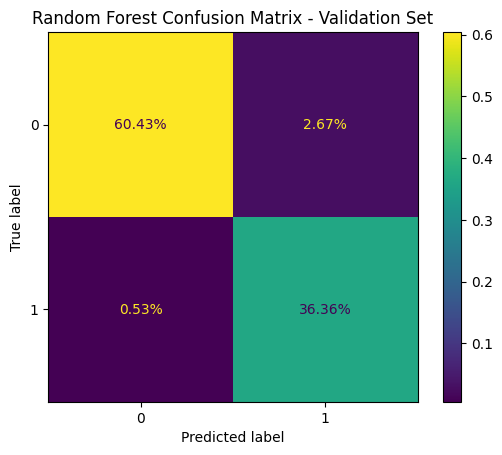

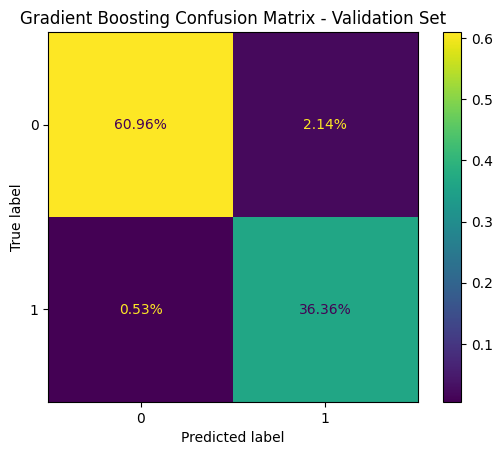

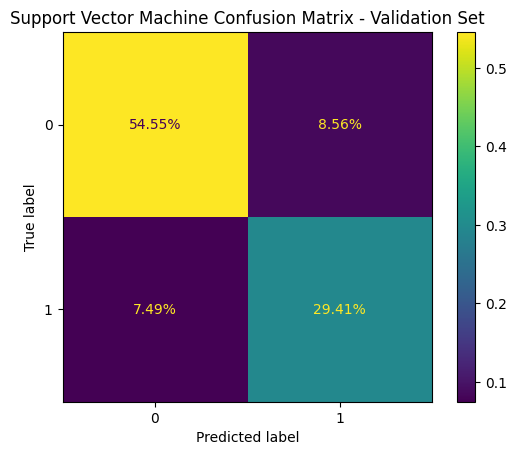

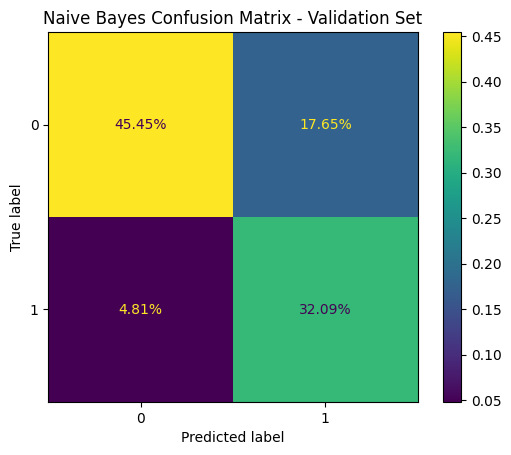

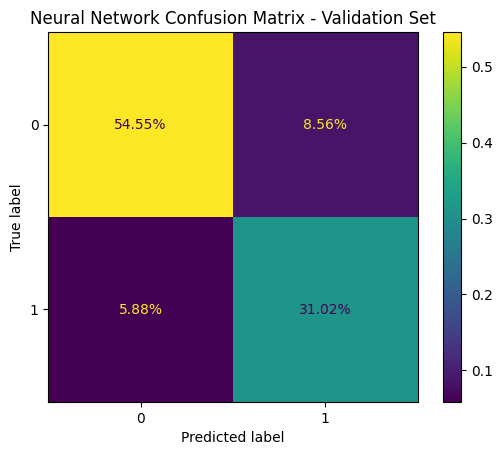

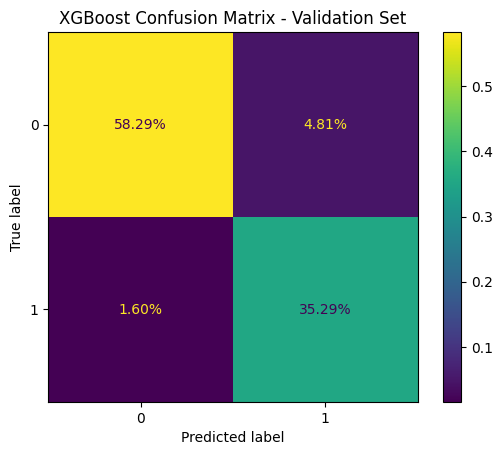

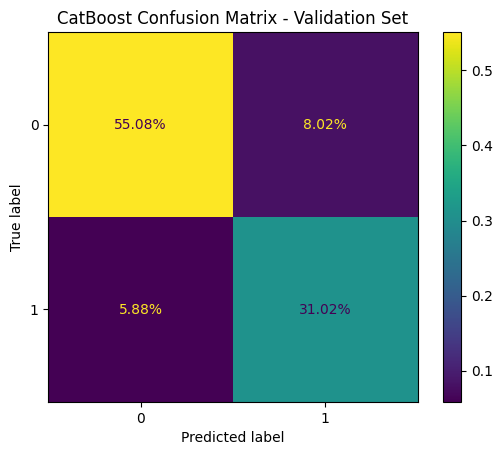

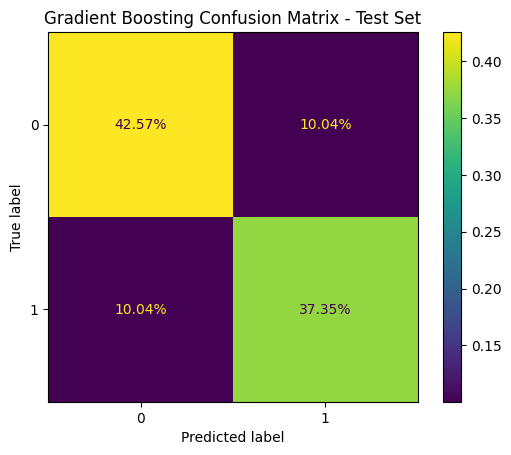

In [72]:
build_model('precision', precision_score)


Setting accuracy as scoring
Logistic Regression - score: 0.8235, Best HP: {'C': 0.01, 'max_iter': 8000, 'solver': 'lbfgs'}, took: 24.81s 
Random Forest - score: 0.8610, Best HP: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}, took: 69.21s 
Gradient Boosting - score: 0.8610, Best HP: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.01}, took: 2.43s 
Support Vector Machine - score: 0.8342, Best HP: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, took: 16.53s 
Naive Bayes - score: 0.7861, Best HP: {'var_smoothing': 1e-09}, took: 0.14s 
Neural Network - score: 0.8503, Best HP: {'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}, took: 3.31s 
XGBoost - score: 0.8663, Best HP: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, '

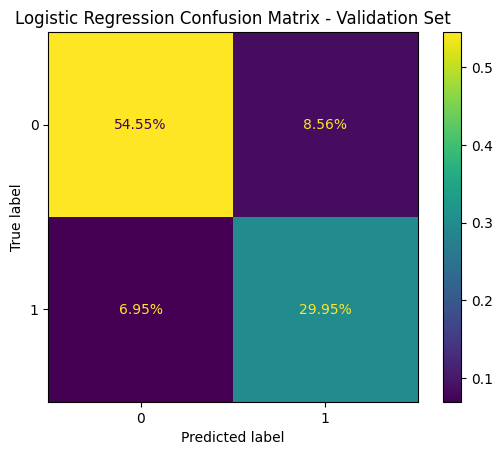

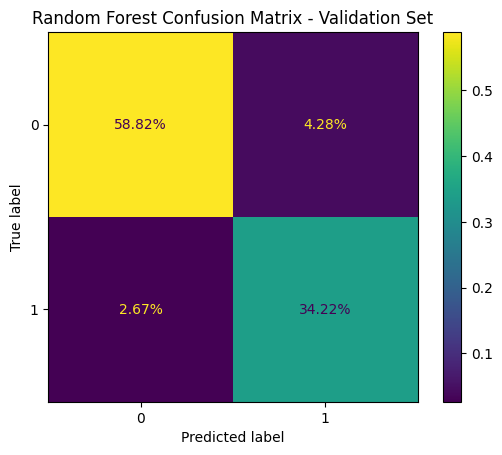

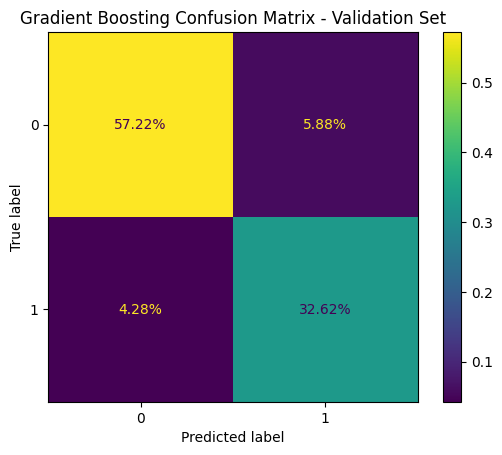

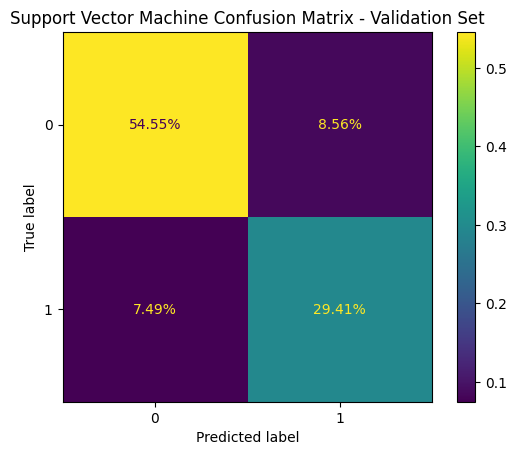

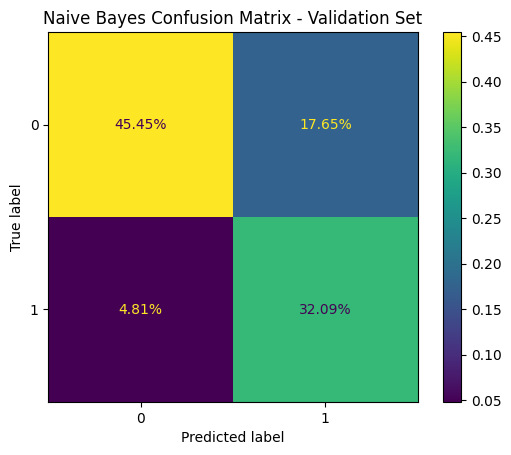

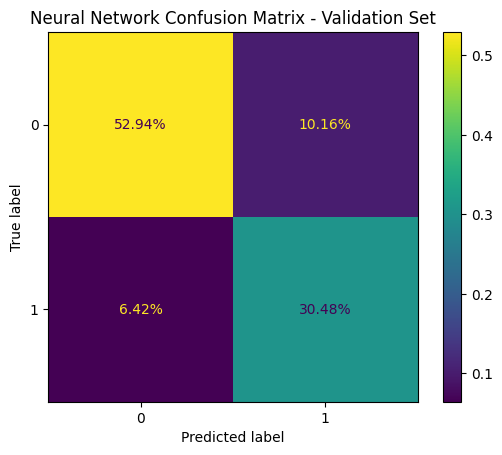

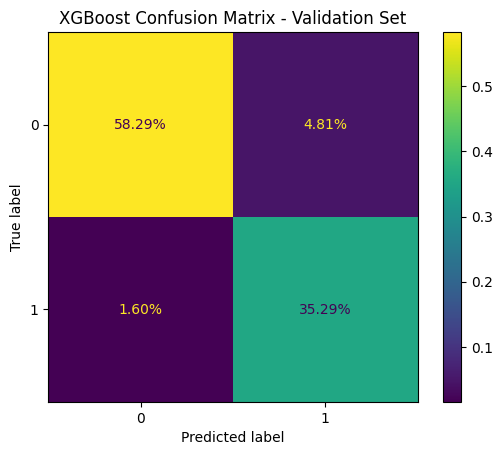

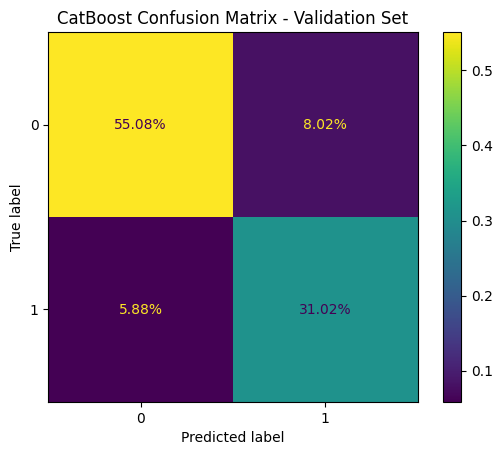

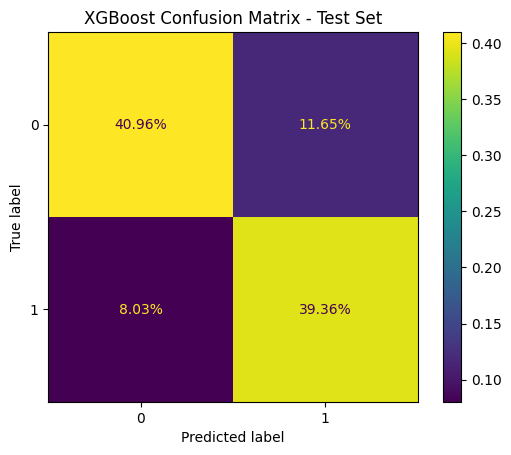

In [73]:
build_model('accuracy', accuracy_score)
